## USDA_analytics
This project is intended to demonstrate the collection of USDA SNOTEL and streamflow data for the purpose of conducting analytics on the relationship between snowpack and streamflow. This data is subject to different parameters in the API requests as needed for different watersheds and time periods but is intended to demonstrate proof of concept. The data is collected from the USDA REST API as JSON objects that are then transformed into CSV files in a local directory and loaded into an S3 bucket using boto3, an AWS SDK.

## Entity Relationship Diagram
The database contains the following tables:

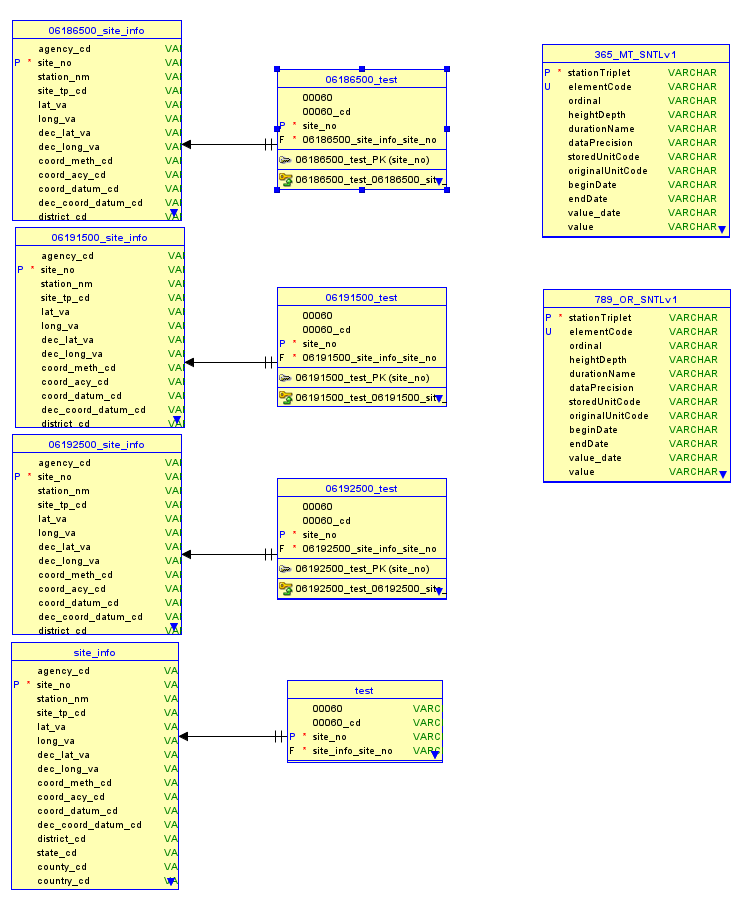

## Collection of Streamflow and SNOTEL data
The streamflow data is collected from the USDA REST API by passing in the site code for the desired water source and the start and end dates for the desired time period. The data is returned as a JSON object. For the purposes of this project, I have altered the code to print a Pandas dataframe that you can use to view the output provided you have the appropriate packages installed in your environment.

In [1]:
import requests
import csv
from io import StringIO
import pandas as pd

def get_streamflow_data(site_code, start_date, end_date):
    base_url = "https://waterservices.usgs.gov/nwis/iv/"
    params = {
        'format': 'json',
        'sites': site_code,
        'parameterCd': '00060',  # Streamflow parameter code
        'startDT': start_date,
        'endDT': end_date,
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: Unable to retrieve data. Status code: {response.status_code}")
        return None

# Pass in variables for 
site_code = "06191500" #<-- Designates the USGS streamflow measurement site
start_date = "2023-01-01"
end_date = "2023-01-31"
streamflow_data = get_streamflow_data(site_code, start_date, end_date)

# Check if streamflow_data is not None
if streamflow_data:
    csv_buffer = StringIO()
    writer = csv.writer(csv_buffer)

    # Write the header row
    writer.writerow(['Site', 'Variable', 'Unit', 'Date', 'Instantaneous Value'])

    # Write the data rows
    for item in streamflow_data['value']['timeSeries']:
        site_name = item['sourceInfo']['siteName']
        variable_description = item['variable']['variableDescription']
        unit = item['variable']['unit']['unitCode']

        for value in item['values'][0]['value']:
            date = value['dateTime']
            inst_value = value['value']

            # Write the data row
            writer.writerow([site_name, variable_description, unit, date, inst_value])

    streamflow_df = pd.read_csv(StringIO(csv_buffer.getvalue()))

    print(streamflow_df)
else:
    print("No data retrieved.")

                                        Site  \
0     Yellowstone River at Corwin Springs MT   
1     Yellowstone River at Corwin Springs MT   
2     Yellowstone River at Corwin Springs MT   
3     Yellowstone River at Corwin Springs MT   
4     Yellowstone River at Corwin Springs MT   
...                                      ...   
2771  Yellowstone River at Corwin Springs MT   
2772  Yellowstone River at Corwin Springs MT   
2773  Yellowstone River at Corwin Springs MT   
2774  Yellowstone River at Corwin Springs MT   
2775  Yellowstone River at Corwin Springs MT   

                              Variable   Unit                           Date  \
0     Discharge, cubic feet per second  ft3/s  2023-01-01T00:00:00.000-07:00   
1     Discharge, cubic feet per second  ft3/s  2023-01-01T00:15:00.000-07:00   
2     Discharge, cubic feet per second  ft3/s  2023-01-01T00:30:00.000-07:00   
3     Discharge, cubic feet per second  ft3/s  2023-01-01T00:45:00.000-07:00   
4     Discharge, cubic 

The file that was initially written for this project would convert the JSON output to a CSV file and write it to the local directory. This was done using the following code:

```# Check if the output directory exists and create it if it doesn't
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the output file
with open(os.path.join(output_dir, 'streamflow_data.csv'), 'w', newline='') as output_file:
    # Create a CSV writer
    writer = csv.writer(output_file)

    # Write the header row
    writer.writerow(['Site', 'Variable', 'Unit', 'Date', 'Instantaneous Value'])

    # Write the data rows
    if streamflow_data:
        for item in streamflow_data['value']['timeSeries']:
            site_name = item['sourceInfo']['siteName']
            variable_description = item['variable']['variableDescription']
            unit = item['variable']['unit']['unitCode']

            for value in item['values'][0]['value']:
                date = value['dateTime']
                inst_value = value['value']

                # Write the data row
                writer.writerow([site_name, variable_description, unit, date, inst_value]) ```

Similarly, the SNOTEL data is collected from the USDA REST API by passing in the appropriate parameters for SNOTEL sites. You can pass in requests for multiple stations within a watershed.

The original code has been modified from writing the data to a CSV file to creating a pandas dataframe. The process for writing the data to a CSV file was structured similarly to the above code snippet.

In [4]:
import requests
import pandas as pd

# Define the base URL for the AWDB REST API
base_url = 'https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1'

# Define the endpoint and parameters for the getData method
endpoint = '/data'
# Here, you can pass in multiple station triplets that Identify the station(s) for which to retrieve data
stationTriplets = ['365:MT:SNTL', '789:OR:SNTL']

params = {
    'elements': 'WTEQ',
    'elementCd': 'in',
    'ordinal': 1,
    'heightDepth': ',',
    'duration': 'DAILY',
    'getFlags': True,
    'beginDate': '2023-01-01 01:00',
    'endDate': '2023-12-18 01:00',
    'stationTriplets': stationTriplets,
}

# Create a list to store DataFrame for each stationTriplet
dataframes = []

# Loop over each station triplet
for stationTriplet in stationTriplets:
    params['stationTriplets'] = stationTriplet

    response = requests.get(base_url + endpoint, params=params)

    try:
        if response.status_code == 200:
            # Parse the JSON data from the response
            data = response.json()

            # Extract information from the JSON data to construct a DataFrame (this was pretty tricky)
            records = []
            for item in data:
                station_triplet = item.get('stationTriplet', '')
                for entry in item.get('data', []):
                    station_element = entry.get('stationElement', {})
                    values = entry.get('values', [])
                    for value_entry in values:
                        record = {
                            'stationTriplet': station_triplet,
                            'elementCode': station_element.get('elementCode', ''),
                            'ordinal': station_element.get('ordinal', ''),
                            'heightDepth': station_element.get('heightDepth', ''),
                            'durationName': station_element.get('durationName', ''),
                            'dataPrecision': station_element.get('dataPrecision', ''),
                            'storedUnitCode': station_element.get('storedUnitCode', ''),
                            'originalUnitCode': station_element.get('originalUnitCode', ''),
                            'beginDate': station_element.get('beginDate', ''),
                            'endDate': station_element.get('endDate', ''),
                            'value_date': value_entry.get('date', ''),
                            'value': value_entry.get('value', ''),
                        }
                        records.append(record)

            # Create a Pandas DataFrame from the records
            df = pd.DataFrame(records)

            dataframes.append(df)

            print(f"Data for {stationTriplet} processed.")
        else:
            print(f"Error: {response.status_code}, {response.text}")
    except requests.RequestException as e:
        print(f"An error occurred during the request: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Concatenate all DataFrames into a single DataFrame
SNOTEL_df = pd.concat(dataframes, ignore_index=True)
SNOTEL_df.head()


Data for 365:MT:SNTL processed.
Data for 789:OR:SNTL processed.


,stationTriplet,elementCode,ordinal,heightDepth,durationName,dataPrecision,storedUnitCode,originalUnitCode,beginDate,endDate,value_date,value
0,365:MT:SNTL,WTEQ,1,,DAILY,1,in,in,1992-10-01 00:00:00.0,2100-01-01 00:00:00.0,2023-01-01,7.5
1,365:MT:SNTL,WTEQ,1,,DAILY,1,in,in,1992-10-01 00:00:00.0,2100-01-01 00:00:00.0,2023-01-02,7.5
2,365:MT:SNTL,WTEQ,1,,DAILY,1,in,in,1992-10-01 00:00:00.0,2100-01-01 00:00:00.0,2023-01-03,7.5
3,365:MT:SNTL,WTEQ,1,,DAILY,1,in,in,1992-10-01 00:00:00.0,2100-01-01 00:00:00.0,2023-01-04,7.5
4,365:MT:SNTL,WTEQ,1,,DAILY,1,in,in,1992-10-01 00:00:00.0,2100-01-01 00:00:00.0,2023-01-05,7.8


Using a boto3 client, an S3 bucket is created and the CSV files are then uploaded to it. NOTE: This will only run if you have an active AWS account and have configured your AWS credentials through the CLI. The variables 'S3_BUCKET_NAME' and 'DIRECTORY' assume a config file with those variables has been created in the home directory.


The code for this is as follows:

In [ ]:
import boto3
import logging
import os
from botocore.exceptions import ClientError
from datetime import datetime
from config import S3_BUCKET_NAME, DIRECTORY
from botonwis import nwis_directory

# Declare your variables
s3 = boto3.resource('s3') # <-- Do not alter this variable.
bucket_name = S3_BUCKET_NAME
directory = DIRECTORY
files = os.listdir(directory) # <-- Do not alter this variable.
region = 'us-west-2'

# Define the function to create a bucket
def create_bucket(bucket_name, region=None):
    """Create an S3 bucket in a specified region

    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).

    :return: True if bucket created, else False
    """

    # Creates a bucket with some error handling. If the bucket already exists, it will print an error message.
    try:
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

# Call the create_bucket function
create_bucket(bucket_name, region)

# Get the list of files in each directory
files = os.listdir("./output")

for file in files:
    if file.endswith('.json') or file.endswith('.csv'):
        file_path = os.path.join(nwis_directory, file)
        
        # Get the current date and format it as 'YYYY/MM/DD'
        current_date = datetime.now()

        # Get the filename without the extension
        filename_without_extension = os.path.splitext(file)[0]

        # Include the filename in the path structure
        path_structure = 'nwis/' + current_date.strftime('%Y/%m/%d/') + filename_without_extension + '/' + file
        
        # Upload the file
        with open(file_path, 'rb') as data:
            s3.Object(bucket_name, path_structure).put(Body=data)
            print(f'Uploaded {file} to {bucket_name} at {path_structure}')

Each CSV is loaded into its own directory within the S3 bucket. This allows for the data to be crawled by an AWS Glue crawler and loaded into an AWS Athena database for querying.

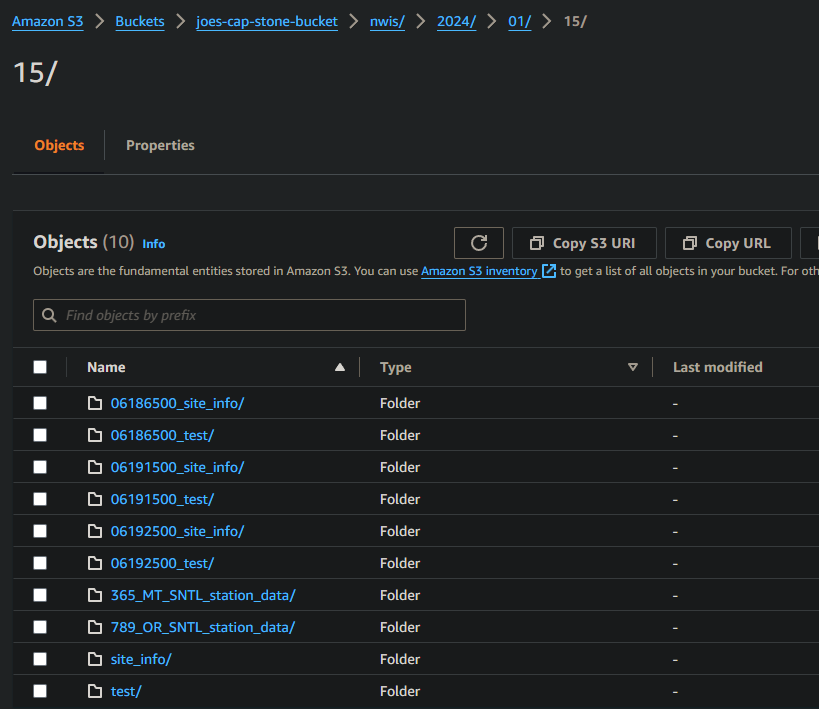

## The next step is to infer the schema from the files in the S3 bucket and create a Glue database.
The code is as follows, first to create a Glue DB (again assuming a config file with the variable 'DATABASE_NAME' has been created in the home directory):

In [ ]:
import boto3
from config import DATABASE_NAME

def create_database(glue_client, database_name):
    try:
        glue_client.create_database(
            DatabaseInput={
                'Name': database_name
            }
        )
        print(f"Created database: {database_name}")
    except Exception as e:
        print(f"Error creating database: {e}")

def main():
    region = 'us-west-2'  # Replace with your AWS region
    database_name = DATABASE_NAME
    # Boto3 Glue client
    glue_client = boto3.client('glue', region_name=region)

    # Create the database
    create_database(glue_client, database_name)

if __name__ == '__main__':
    main()

Next, a Glue Crawler is created to crawl the data in the S3 bucket, infer schemas and create tables in the Glue DB.

In [ ]:
import boto3
import time

def create_crawler(glue_client, crawler_name, s3_path, database_name):
    try:
        glue_client.create_crawler(
            Name=crawler_name,
            Role='arn:aws:iam::459793645210:role/service-role/AWSGlueServiceRole',  # Use your Glue IAM role ARN, this will not work unless you have my credentials.
            DatabaseName=database_name,
            Targets={
                'S3Targets': [{'Path': s3_path}]
            },
        )
        return crawler_name
    except Exception as e:
        print(f"Error creating crawler: {e}")
        return None

def start_crawler(glue_client, crawler_name):
    try:
        glue_client.start_crawler(Name=crawler_name)
        print(f"Started crawler: {crawler_name}")
    except Exception as e:
        print(f"Error starting crawler: {e}")

def wait_for_crawler(glue_client, crawler_name):
    while True:
        try:
            response = glue_client.get_crawler(Name=crawler_name)
            status = response['Crawler']['State']
            print(f"Crawler {crawler_name} status: {status}")

            if status == 'READY':
                break
        except KeyError:
            print("Error: 'Crawler' key not found in the response.")
            break
        except glue_client.exceptions.EntityNotFoundException:
            print(f"Crawler {crawler_name} not found. Possibly not created yet.")
            break
        except Exception as e:
            print(f"Error while checking crawler status: {e}")

        time.sleep(60)

def main():
    try:
        # AWS Glue parameters
        region = 'us-west-2'  # Region to run the crawler in
        database_name = 'joecapstonedb'  # Name of glue DB
        s3_bucket = 'joes-cap-stone-bucket'  # Name of S3 bucket data is stored in
        glue_client = boto3.client('glue', region_name=region)

        # Create and start the crawler
        crawler_name = 'capstone-crawler'
        s3_path = f's3://{s3_bucket}/nwis/'
        crawler_name = create_crawler(glue_client, crawler_name, s3_path, database_name)
        start_crawler(glue_client, crawler_name)

        # Wait for the crawler to finish
        wait_for_crawler(glue_client, crawler_name)
        print("Crawling completed successfully!")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == '__main__':
    main()

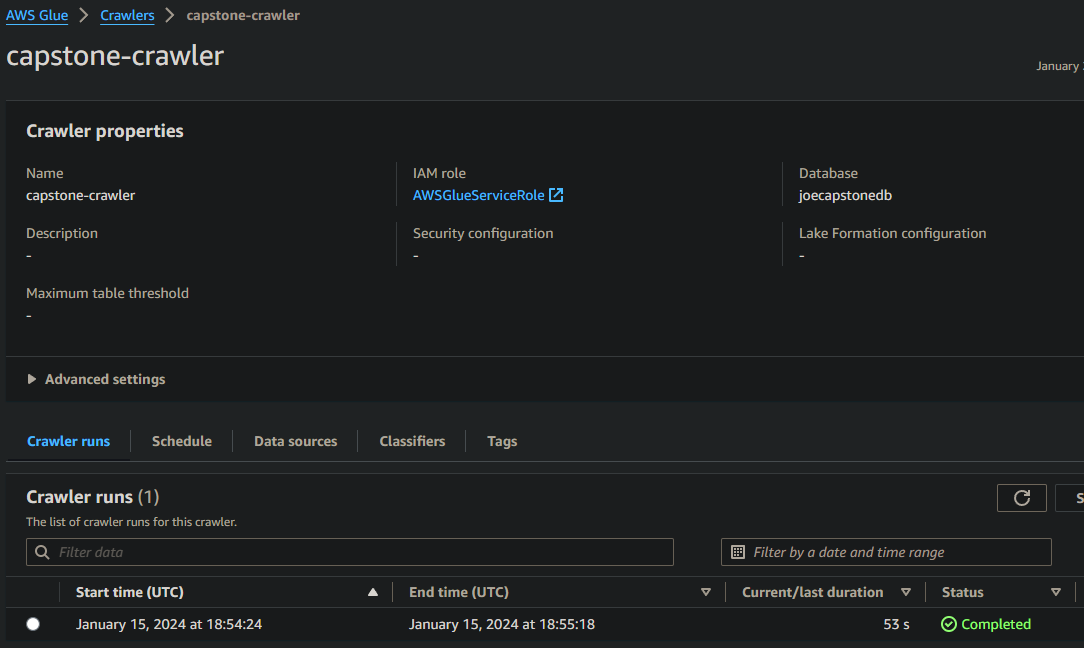

After the crawler runs, the tables are created in the Glue DB. The tables then can be queried using Athena to verify data integrity.

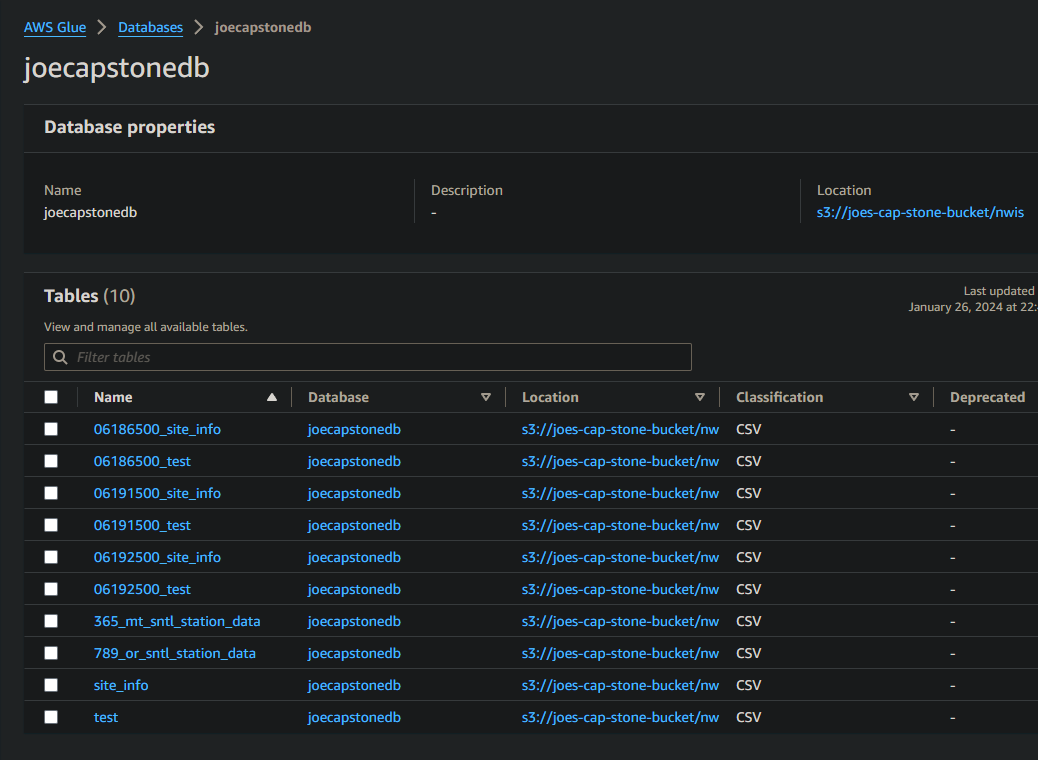

## Creating a Data Lake
Here, boto3 is used to programatically designate a Lake Formation data location and assign permissions.

In [ ]:
import boto3
from botocore.exceptions import ClientError

# Create some clients
iam = boto3.client('iam')
lf = boto3.client('lakeformation')
policy_arn = 'arn:aws:iam::aws:policy/AWSLakeFormationDataAdmin' #<-- Policy must be configured for your account
iam_user = 'BillyBob' #<-- Use your own IAM user

#This method attaches the data lake admin policy to the specified IAM user
iam.attach_user_policy(
   UserName=iam_user,
   PolicyArn=policy_arn
)

# Check if the policy has been successfully attached
response = iam.list_attached_user_policies(UserName=iam_user)
attached_policies = [policy['PolicyArn'] for policy in response['AttachedPolicies']]
if policy_arn in attached_policies:
    print("The policy has been successfully attached.")
else:
    print("The policy has not been attached.")

# This registers an S3 bucket as a resource in Lake Formation
try:
    lf.register_resource(
       ResourceArn='arn:aws:s3:::joes-cap-stone-bucket/nwis/',
       RoleArn='arn:aws:iam::459793645210:role/aws-service-role/lakeformation.amazonaws.com/AWSServiceRoleForLakeFormationDataAccess'
    )
except ClientError as e:
    if e.response['Error']['Code'] == 'AlreadyExistsException':
        print("The resource is already registered.")
    else:
        print(f"Unexpected error: {e}")

This shows the above script registers a location as a data lake in Lake Formation:

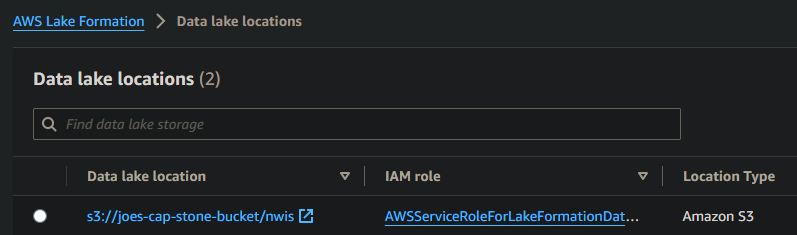

## Data Warehouse with Redshift
Here, boto3 is used to programatically create a Redshift cluster and assign permissions.

In [ ]:
import boto3
import time
from botocore.exceptions import ClientError

# Create a redshift client
redshift = boto3.client('redshift')

# Declare parameters as variables
cluster_identifier = 'joes-capstone-cluster'
database = 'joescapstonedb'
user = 'billybob'
password = 'Capstone69'
port = '5439'

def create_redshift_cluster():
    try:
        response = redshift.create_cluster(
            ClusterIdentifier=cluster_identifier,
            NodeType='dc2.large',
            MasterUsername=user,
            MasterUserPassword=password,
            DBName=database,
            ClusterType='single-node',
            AvailabilityZone='us-west-2a',
            # Add IAM roles to allow Redshift to access S3, again, replace with your own IAM roles
            IamRoles=[
                'arn:aws:iam::459793645210:role/service-role/AmazonRedshift-CommandsAccessRole-20231031T191434',
                'arn:aws:iam::459793645210:role/spectrumRole',
                'arn:aws:iam::459793645210:role/aws-service-role/redshift.amazonaws.com/AWSServiceRoleForRedshift'
            ],
            PubliclyAccessible=True
        )
        print("Redshift cluster created successfully!")
        return response
    except ClientError as e:
        if e.response['Error']['Code'] == 'ClusterAlreadyExists':
            print("Redshift cluster already exists. Continuing...")
        else:
            raise

create_redshift_cluster()

# Check the status of the cluster until it becomes available
while True:
    response = redshift.describe_clusters(ClusterIdentifier=cluster_identifier)
    cluster_status = response['Clusters'][0]['ClusterStatus']
    print(f"Cluster status: {cluster_status}")
    if cluster_status == 'available':
        break
    time.sleep(60)  # Wait for 60 seconds

Below are images that verify that the above script creates a Redshift cluster

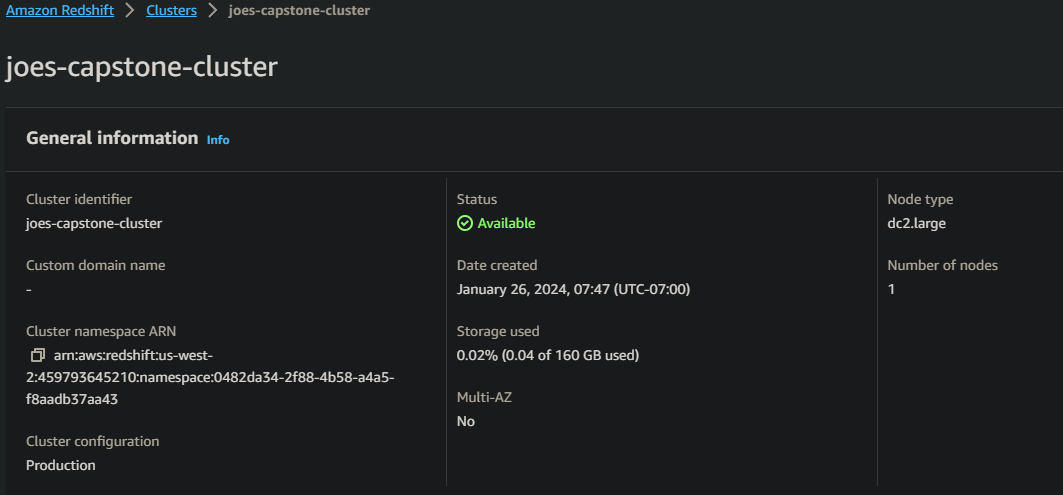

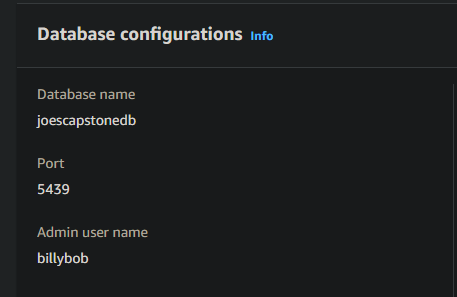

This is the DDL for creating the tables in Redshift, the schema was extracted by a Python script in the local directory.

In [ ]:
CREATE EXTERNAL SCHEMA capstone
FROM data catalog
database 'joescapstonedb'
iam_role 'arn:aws:iam::459793645210:role/spectrumRole'
CREATE EXTERNAL DATABASE IF NOT EXISTS;

CREATE EXTERNAL TABLE capstone."06186500_site_info" (
agency_cd VARCHAR,
site_no VARCHAR,
station_nm VARCHAR,
site_tp_cd VARCHAR,
lat_va VARCHAR,
long_va VARCHAR,
dec_lat_va VARCHAR,
dec_long_va VARCHAR,
coord_meth_cd VARCHAR,
coord_acy_cd VARCHAR,
coord_datum_cd VARCHAR,
dec_coord_datum_cd VARCHAR,
district_cd VARCHAR,
state_cd VARCHAR,
county_cd VARCHAR,
country_cd VARCHAR,
land_net_ds VARCHAR,
map_nm VARCHAR,
map_scale_fc VARCHAR,
alt_va VARCHAR,
alt_meth_cd VARCHAR,
alt_acy_va VARCHAR,
alt_datum_cd VARCHAR,
huc_cd VARCHAR,
basin_cd VARCHAR,
topo_cd VARCHAR,
instruments_cd VARCHAR,
construction_dt VARCHAR,
inventory_dt VARCHAR,
drain_area_va VARCHAR,
contrib_drain_area_va VARCHAR,
tz_cd VARCHAR,
local_time_fg VARCHAR,
reliability_cd VARCHAR,
gw_file_cd VARCHAR,
nat_aqfr_cd VARCHAR,
aqfr_cd VARCHAR,
aqfr_type_cd VARCHAR,
well_depth_va VARCHAR,
hole_depth_va VARCHAR,
depth_src_cd VARCHAR,
project_no VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE capstone."06186500_test" (
00060 VARCHAR,
00060_cd VARCHAR,
site_no VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE capstone."06191500_site_info" (
agency_cd VARCHAR,
site_no VARCHAR,
station_nm VARCHAR,
site_tp_cd VARCHAR,
lat_va VARCHAR,
long_va VARCHAR,
dec_lat_va VARCHAR,
dec_long_va VARCHAR,
coord_meth_cd VARCHAR,
coord_acy_cd VARCHAR,
coord_datum_cd VARCHAR,
dec_coord_datum_cd VARCHAR,
district_cd VARCHAR,
state_cd VARCHAR,
county_cd VARCHAR,
country_cd VARCHAR,
land_net_ds VARCHAR,
map_nm VARCHAR,
map_scale_fc VARCHAR,
alt_va VARCHAR,
alt_meth_cd VARCHAR,
alt_acy_va VARCHAR,
alt_datum_cd VARCHAR,
huc_cd VARCHAR,
basin_cd VARCHAR,
topo_cd VARCHAR,
instruments_cd VARCHAR,
construction_dt VARCHAR,
inventory_dt VARCHAR,
drain_area_va VARCHAR,
contrib_drain_area_va VARCHAR,
tz_cd VARCHAR,
local_time_fg VARCHAR,
reliability_cd VARCHAR,
gw_file_cd VARCHAR,
nat_aqfr_cd VARCHAR,
aqfr_cd VARCHAR,
aqfr_type_cd VARCHAR,
well_depth_va VARCHAR,
hole_depth_va VARCHAR,
depth_src_cd VARCHAR,
project_no VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE capstone."06191500_test" (
00060 VARCHAR,
00060_cd VARCHAR,
site_no VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE capstone."06192500_site_info" (
agency_cd VARCHAR,
site_no VARCHAR,
station_nm VARCHAR,
site_tp_cd VARCHAR,
lat_va VARCHAR,
long_va VARCHAR,
dec_lat_va VARCHAR,
dec_long_va VARCHAR,
coord_meth_cd VARCHAR,
coord_acy_cd VARCHAR,
coord_datum_cd VARCHAR,
dec_coord_datum_cd VARCHAR,
district_cd VARCHAR,
state_cd VARCHAR,
county_cd VARCHAR,
country_cd VARCHAR,
land_net_ds VARCHAR,
map_nm VARCHAR,
map_scale_fc VARCHAR,
alt_va VARCHAR,
alt_meth_cd VARCHAR,
alt_acy_va VARCHAR,
alt_datum_cd VARCHAR,
huc_cd VARCHAR,
basin_cd VARCHAR,
topo_cd VARCHAR,
instruments_cd VARCHAR,
construction_dt VARCHAR,
inventory_dt VARCHAR,
drain_area_va VARCHAR,
contrib_drain_area_va VARCHAR,
tz_cd VARCHAR,
local_time_fg VARCHAR,
reliability_cd VARCHAR,
gw_file_cd VARCHAR,
nat_aqfr_cd VARCHAR,
aqfr_cd VARCHAR,
aqfr_type_cd VARCHAR,
well_depth_va VARCHAR,
hole_depth_va VARCHAR,
depth_src_cd VARCHAR,
project_no VARCHARR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE capstone."06192500_test" (
00060 VARCHAR,
00060_cd VARCHAR,
site_no VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE capstone."365_mt_sntl_station_data" (
stationTriplet VARCHAR,
elementCode VARCHAR,
ordinal VARCHAR,
heightDepth VARCHAR,
durationName VARCHAR,
dataPrecision VARCHAR,
storedUnitCode VARCHAR,
originalUnitCode VARCHAR,
beginDate VARCHAR,
endDate VARCHAR,
value_date VARCHAR,
value VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';

CREATE EXTERNAL TABLE caspstone."789_or_sntl_station_data" (
stationTriplet VARCHAR,
elementCode VARCHAR,
ordinal VARCHAR,
heightDepth VARCHAR,
durationName VARCHAR,
dataPrecision VARCHAR,
storedUnitCode VARCHAR,
originalUnitCode VARCHAR,
beginDate VARCHAR,
endDate VARCHAR,
value_date VARCHAR,
value VARCHAR
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://joes-cap-stone-bucket/nwis/';